In [44]:
import re
import ast
import os

import pandas as pd

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import seaborn as sns

In [32]:
%run ./scripts/store_model_performance.py
%run ./scripts/atomic_benchmark_estimator.py

# 8. GridSearchCV extract
```python
"[CV 1/6] END batch_size=10, epochs=10, first_activation=tanh, first_n_nodes=128, layers=[['tanh', 'tanh'], [128, 64]], model_opt=adam;, score=-187.800 total time= 6.1min"
```

In [2]:
pattern = re.compile("^\[CV \d\/\d\] END batch_size=(\d+), epochs=(\d+), first_activation=(.+), first_n_nodes=(\d+), layers=(\[.*]), model_opt=(.+);, score=(-?[\d.]+) total time= ([\d.]+)min$")

In [3]:
item_names = ["batch_size", "epochs", "first_activation", "first_n_nodes", "layers", "model_opt", "score", "time"]
lst = []

with open("data/007.gridsearchcv-output.log") as file:
    for line in file.readlines():
        if groups := pattern.findall(line):
            lst.append({name: value for name, value in zip(item_names, groups[0])})

df_grid_search = pd.DataFrame(lst).sort_values("score")
df_grid_search

,batch_size,epochs,first_activation,first_n_nodes,layers,model_opt,score,time
86,10,10,tanh,64,"[['tanh', 'tanh'], [64, 128]]",adam,-186.759,6.2
139,10,10,tanh,128,"[['tanh', 'tanh'], [64, 128]]",adam,-187.076,6.5
109,10,10,tanh,64,"[['tanh', 'tanh'], [128, 128]]",adam,-187.289,6.8
121,10,10,tanh,128,"[['tanh', 'tanh'], [10, 64]]",adam,-187.334,6.1
102,10,10,tanh,64,"[['tanh', 'tanh'], [128, 128]]",adam,-187.348,7.6
...,...,...,...,...,...,...,...,...
127,10,10,tanh,128,"[['tanh', 'tanh'], [64, 10]]",adam,-791.972,3.7
87,10,10,tanh,64,"[['tanh', 'tanh'], [128, 10]]",adam,-792.031,3.0
180,10,30,tanh,128,"[['tanh', 'tanh'], [10, 10]]",adam,-792.082,4.1
30,10,10,tanh,10,"[['tanh', 'tanh'], [128, 10]]",adam,-792.127,3.0


In [4]:
df_grid_search.dtypes

batch_size          object
epochs              object
first_activation    object
first_n_nodes       object
layers              object
model_opt           object
score               object
time                object
dtype: object

In [5]:
df_grid_search[["score", "time"]] = df_grid_search[["score", "time"]].astype(float)

In [6]:
df_grid_search[["batch_size", "epochs", "first_n_nodes"]] = df_grid_search[["batch_size", "epochs", "first_n_nodes"]].astype(int)

In [7]:
df_grid_search["layers"] = df_grid_search["layers"].map(ast.literal_eval)

In [8]:
df_grid_search.dtypes

batch_size            int32
epochs                int32
first_activation     object
first_n_nodes         int32
layers               object
model_opt            object
score               float64
time                float64
dtype: object

In [9]:
df_grid_search.iloc[0]

batch_size                                 10
epochs                                     10
first_activation                         tanh
first_n_nodes                              64
layers              [[tanh, tanh], [64, 128]]
model_opt                                adam
score                                -186.759
time                                      6.2
Name: 86, dtype: object

## 8.1. Load data

In [10]:
df = pd.read_pickle("./pickles/003.dataframe.data-preprocessing.pkl")
df

,price,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,review_scores_rating,...,Shampoo,Smoke alarm,Stove,TV,Washer,Wifi,Entire place,Hotel room,Private room,Shared room
0,53,0,0.000138,1,0,0.543185,0.012963,0.066667,0.0,1.0,...,0,0,0,0,1,1,1.0,0.0,0.0,0.0
1,120,0,0.000138,1,1,0.543180,0.013029,0.066667,0.0,1.0,...,1,0,0,0,1,1,1.0,0.0,0.0,0.0
2,89,0,0.000138,1,0,0.543124,0.012873,0.066667,0.0,1.0,...,0,0,0,1,1,1,1.0,0.0,0.0,0.0
3,58,0,0.000138,1,1,0.542730,0.012810,0.066667,0.0,1.0,...,0,0,0,1,0,1,1.0,0.0,0.0,0.0
4,60,0,0.000138,1,0,0.542833,0.012610,0.066667,0.0,1.0,...,0,0,0,1,1,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279707,120,0,0.000138,1,1,0.542522,0.012857,0.066667,0.0,1.0,...,0,1,0,1,1,1,1.0,0.0,0.0,0.0
279708,60,0,0.000138,1,1,0.543257,0.012956,0.066667,0.0,1.0,...,1,0,0,1,1,1,1.0,0.0,0.0,0.0
279709,50,0,0.000138,1,1,0.543189,0.013051,0.066667,0.0,1.0,...,1,0,0,0,1,1,1.0,0.0,0.0,0.0
279710,105,0,0.000138,1,1,0.542965,0.013229,0.066667,0.0,1.0,...,1,1,0,1,1,1,1.0,0.0,0.0,0.0


## 8.2. Create model

In [11]:
input_size = df.shape[1] - 1
input_size

63

In [12]:
def create_model(layers, model_opt, first_activation, first_n_nodes):
    model = keras.models.Sequential()

    model.add(Dense(first_n_nodes, input_shape=(input_size,), activation=first_activation))

    for act, n_nodes in zip(*layers):
        model.add(Dense(n_nodes, activation=act))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=model_opt,
        loss="mae",
    )
    
    return model

In [13]:
model = create_model(**{k: df_grid_search.iloc[0][k] for k in ["layers", "model_opt", "first_activation", "first_n_nodes"]})

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4096      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16,705
Trainable params: 16,705
Non-trainable params: 0
_________________________________________________________________


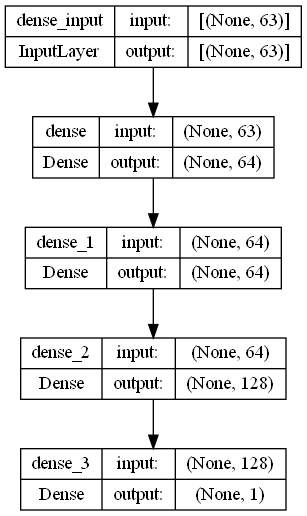

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 8.3. Split train validate test

In [16]:
train_size = .8
validate_size = .1
test_size = .1

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], random_state=42, train_size=train_size+test_size)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, train_size=train_size/(train_size+test_size))

In [19]:
X_train.shape[0], X_val.shape[0], X_test.shape[0], df.shape[0]

(223679, 27960, 27960, 279599)

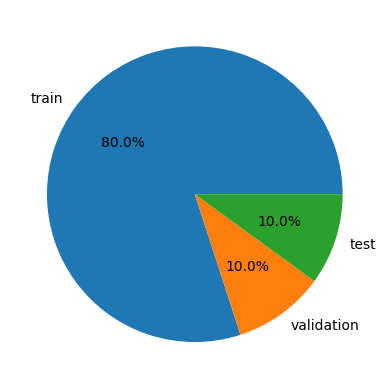

In [20]:
plt.pie([X_train.shape[0], X_val.shape[0], X_test.shape[0]], labels=["train", "validation", "test"], autopct='%1.1f%%')
plt.show()

## 8.4. Train

In [21]:
df_grid_search.iloc[0]

batch_size                                 10
epochs                                     10
first_activation                         tanh
first_n_nodes                              64
layers              [[tanh, tanh], [64, 128]]
model_opt                                adam
score                                -186.759
time                                      6.2
Name: 86, dtype: object

In [22]:
model_path = "./pickles/008.sequential-grid-searched.h5"

In [23]:
early_stopping_cb = EarlyStopping(patience=3, monitor="val_loss")

In [24]:
history = model.fit(
    x=X_train.to_numpy().astype(np.float32),
    y=y_train.to_numpy().astype(np.float32),
    validation_data=(X_val.to_numpy().astype(np.float32), y_val.to_numpy().astype(np.float32)),

    batch_size=df_grid_search.iloc[0]["batch_size"],
    epochs=60,
    callbacks=[early_stopping_cb],
)

Epoch 1/60
22368/22368 [==============================] - 25s 1ms/step - loss: 456.5957 - val_loss: 408.7748
Epoch 2/60
22368/22368 [==============================] - 25s 1ms/step - loss: 378.1480 - val_loss: 392.0148
Epoch 3/60
22368/22368 [==============================] - 25s 1ms/step - loss: 366.0435 - val_loss: 380.5559
Epoch 4/60
22368/22368 [==============================] - 24s 1ms/step - loss: 359.3774 - val_loss: 376.4387
Epoch 5/60
22368/22368 [==============================] - 24s 1ms/step - loss: 354.8491 - val_loss: 372.7109
Epoch 6/60
22368/22368 [==============================] - 24s 1ms/step - loss: 351.1687 - val_loss: 376.1659
Epoch 7/60
22368/22368 [==============================] - 24s 1ms/step - loss: 348.0763 - val_loss: 367.7175
Epoch 8/60
22368/22368 [==============================] - 24s 1ms/step - loss: 345.6789 - val_loss: 367.3052
Epoch 9/60
22368/22368 [==============================] - 24s 1ms/step - loss: 343.3500 - val_loss: 363.3373
Epoch 10/60
22368/2

In [37]:
model.save(model_path)

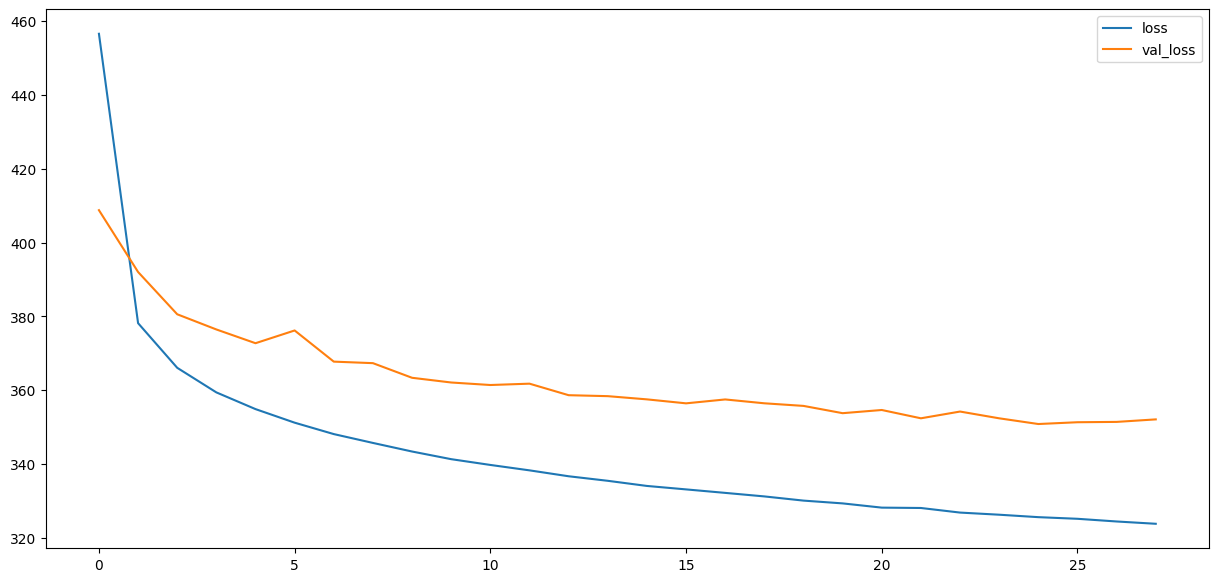

In [31]:
plt.figure(figsize=(15, 7))

for d in history.history.values():
    plt.plot(d)

plt.legend(history.history.keys())

## 8.5. Score

In [38]:
pred = model.predict(X_test)
pred

874/874 [==============================] - 1s 781us/step


array([[136.31099 ],
       [ 65.85764 ],
       [536.8732  ],
       ...,
       [ 76.5296  ],
       [ 67.125786],
       [ 93.807014]], dtype=float32)

In [53]:
mae = mean_absolute_error(y_test, pred)
mae

337.28029759649894

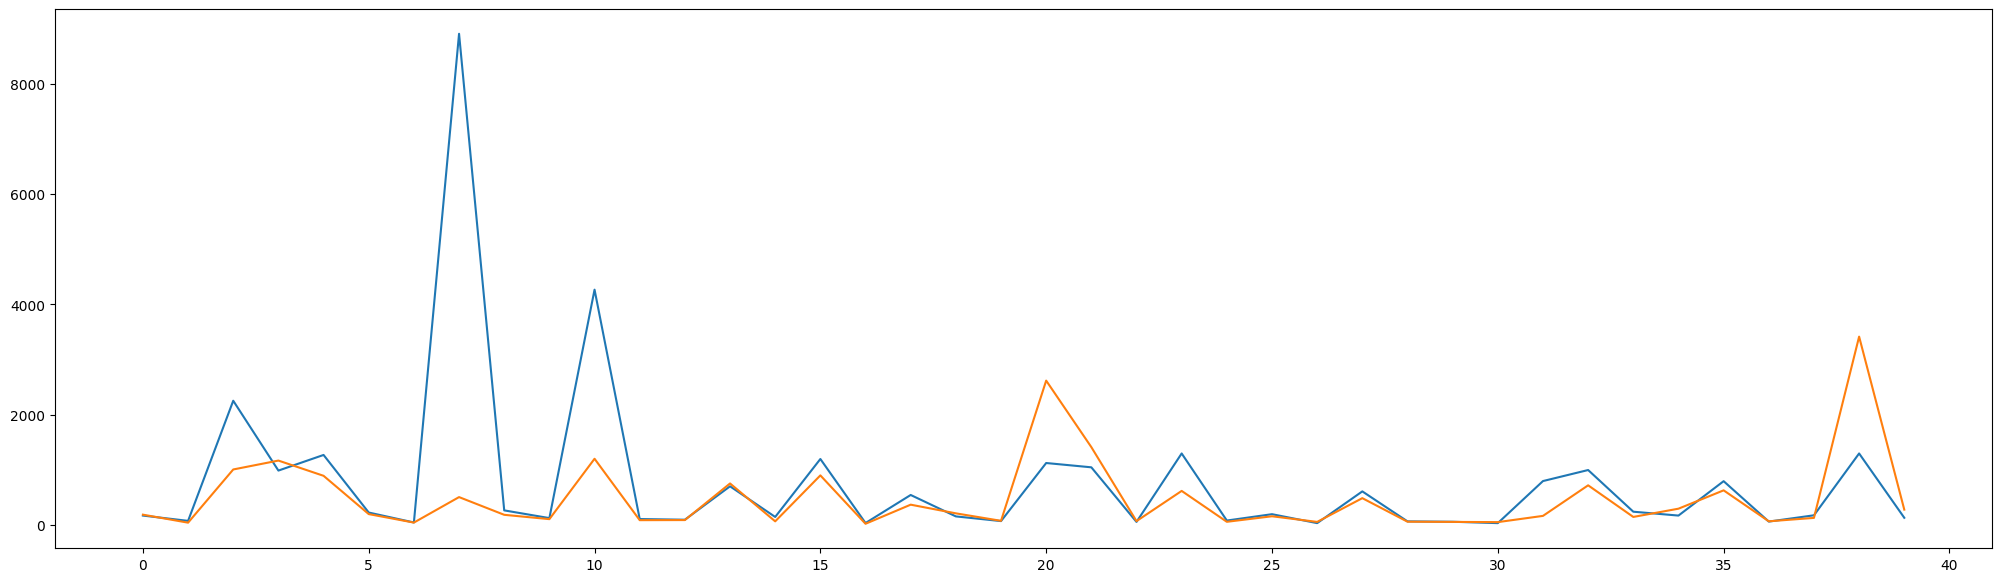

In [40]:
rng = slice(340, 380)

plt.figure(figsize=(25, 7))
plt.plot(y_test[rng].values)
plt.plot(pred[rng])

In [41]:
results = atomic_benchmark_estimator(model, X_test[:5000], verbose=True, kwargs_estimator_predict=dict(verbose=0))

atomic_benchmark runtimes: 0.05338335037231445 0.057189106941223145 0.26746559143066406


<Axes: >

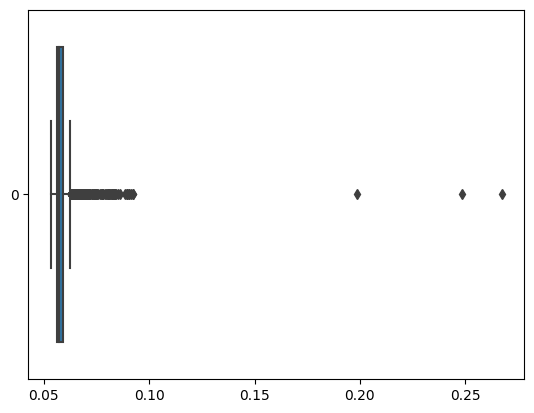

In [43]:
sns.boxplot(results, orient="h")

In [45]:
score = r2_score(y_test, pred)
score

0.09750080090539315

In [54]:
store_model_performance(
    model_name="grid-searched-2",
    R2_score=score,
    mae=mae,
    avarage_predication_time=results.mean(),
    parameters=df_grid_search.iloc[0][["batch_size", "first_activation", "first_n_nodes", "layers", "model_opt"]].to_dict(),
)